# Проект: телекоммуникации. Прогноз оттока клиентов для "ТелеДом"

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. **Задача проекта** — обучить на этих данных модель для прогноза оттока клиентов.


**Описание услуг:**

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:

contract_new.csv — информация о договоре;
personal_new.csv — персональные данные клиента;
internet_new.csv — информация об интернет-услугах;
phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

customerID — идентификатор абонента;
BeginDate — дата начала действия договора;
EndDate — дата окончания действия договора;
Type — тип оплаты: раз в год-два или ежемесячно;
PaperlessBilling — электронный расчётный лист;
PaymentMethod — тип платежа;
MonthlyCharges — расходы за месяц;
TotalCharges — общие расходы абонента.

Файл personal_new.csv

customerID — идентификатор пользователя;
gender — пол;
SeniorCitizen — является ли абонент пенсионером;
Partner — есть ли у абонента супруг или супруга;
Dependents — есть ли у абонента дети.

Файл internet_new.csv

customerID — идентификатор пользователя;
InternetService — тип подключения;
OnlineSecurity — блокировка опасных сайтов;
OnlineBackup — облачное хранилище файлов для резервного копирования данных;
DeviceProtection — антивирус;
TechSupport — выделенная линия технической поддержки;
StreamingTV — стриминговое телевидение;
StreamingMovies — каталог фильмов.

Файл phone_new.csv

customerID — идентификатор пользователя;
MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы:**

Шаг 1. Загрузка данных

Шаг 2. Исследовательский анализ и предобработка данных

Шаг 3. Объединение данных

Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Шаг 5. Подготовка данных

Шаг 6. Обучение моделей машинного обучения

Шаг 7. Выбор лучшей модели

Шаг 8. Общий вывод и рекомендации заказчику


In [1]:
!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.5.1 -q
!pip install shap 
!pip install phik -q

import os
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import phik
import lightgbm as lgb

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

RANDOM_STATE = 270125

     |████████████████████████████████| 539 kB 1.5 MB/s eta 0:00:01


## Загрузка данных

Загрузим данные и выполним их первичный осмотр.

In [2]:
pth1 = '/datasets/contract_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/contract_new.csv'

if os.path.exists(pth1):
    data_contract = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_contract = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(data_contract.head())
data_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
pth3 = '/datasets/personal_new.csv'
pth4 = 'https://code.s3.yandex.net/datasets/personal_new.csv'

if os.path.exists(pth1):
    data_personal = pd.read_csv(pth3)
elif os.path.exists(pth2):
    data_personal = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
display(data_personal.head())
data_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [4]:
pth5 = '/datasets/internet_new.csv'
pth6 = 'https://code.s3.yandex.net/datasets/internet_new.csv'

if os.path.exists(pth1):
    data_internet = pd.read_csv(pth5)
elif os.path.exists(pth2):
    data_internet = pd.read_csv(pth6)
else:
    print('Something is wrong')
    
display(data_internet.head())
data_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
pth7 = '/datasets/phone_new.csv'
pth8 = 'https://code.s3.yandex.net/datasets/phone_new.csv'

if os.path.exists(pth1):
    data_phone = pd.read_csv(pth7)
elif os.path.exists(pth2):
    data_phone = pd.read_csv(pth8)
else:
    print('Something is wrong')
    
display(data_phone.head())
data_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Выводы:

В датафрейме data_contract 7043 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, TotalChargesm тип данных object, в столбцах MonthlyCharges тип данных float.

В датафрейме data_personal 7043 записи, названия столбцов адекватны содержащимся в них данным, в столбцах SeniorCitizen тип данных int, в столбцах customerID, gender, Partner, Dependents тип данных object.

В датафрейме data_internet 5517 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies тип данных object.

В датафрейме data_phone 6361 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, MultipleLines тип данных object.

Требуется исследовательский анализ и предобработка данных: изменение названий столбцов, типов столбцов, проверка наличия пропусков и дубликатов в данных.

##  Исследовательский анализ и предобработка данных

Выполним исследовательский анализ каждого датафрейма и предобработку. Сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

In [6]:
# проверяем наличие пропущенных значений в датафреймах
data_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [7]:
data_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [8]:
data_internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [9]:
data_phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [10]:
# проверяем наличие явных дубликатов в датафреймах
data_contract.duplicated().sum()

0

In [11]:
data_personal.duplicated().sum()

0

In [12]:
data_internet.duplicated().sum()

0

In [13]:
data_phone.duplicated().sum()

0

In [14]:
# переименуем столбцы
data_contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [15]:
data_contract=data_contract.rename(columns={'customerID':'customer_id','BeginDate':'begin_date','EndDate':'end_date',
                                            'Type':'type','PaperlessBilling':'paperless_billing',
                                            'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges', 
                                            'TotalCharges':'total_charges',})

In [16]:
data_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [17]:
data_personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [18]:
data_personal=data_personal.rename(columns={'customerID':'customer_id','SeniorCitizen':'senior_citizen','Partner':'partner',
                                            'Dependents':'dependents'})

In [19]:
data_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [20]:
data_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [21]:
data_internet=data_internet.rename(columns={'customerID':'customer_id','InternetService':'internet_service',
                                            'OnlineSecurity':'online_security','OnlineBackup':'online_backup', 
                                            'DeviceProtection':'device_protection','TechSupport':'tech_support',
                                            'StreamingTV':'streaming_tv','StreamingMovies':'streaming_movies'})

In [22]:
data_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [23]:
data_phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [24]:
data_phone=data_phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})

In [25]:
data_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [26]:
# преобразуем данные в нужные типы
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [27]:
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'])
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], errors='coerce')

При попытке изменить типа данных в столбце 'total_charges' на float выяснилось, что в значениях присутствуют пропуски.

In [28]:
data_contract[data_contract['total_charges'] == " "]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


Все пропуски приходятся на begin_date 2020-02-01. При этом нам известно, что информация о договорах актуальна на 1 февраля 2020 года.

In [29]:
data_contract[data_contract['begin_date'] == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


Подобных данных немного и принято решение их удалить после объединения таблиц

In [30]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [31]:
data_contract.shape

(7043, 8)

In [32]:
data_personal.shape

(7043, 5)

In [33]:
data_internet.shape

(5517, 8)

In [34]:
data_phone.shape

(6361, 2)

Выводы:

Были проверено, нет ли пропущенных значений;

Было проверено наличие явных и не явных дубликатов;

Исправлены ошибки в написании названий столбцов;

Требуется изменение типа данных в столбце 'total_charges' датафрейма data_contract. 

Для более подробного исследовательского анализа проведем объединение данных. Сделаем выводы об имеющихся признаках после проведения анализа.

##  Объединение данных

Объединим признаки в один датафрейм по ключу.

In [35]:
data = (data_personal
      .merge(data_contract, how="left", on="customer_id")
      .merge(data_phone, how="left", on="customer_id")
      .merge(data_internet, how="left", on="customer_id"))

In [36]:
display(data.head())
data.info()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.6,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.5,No,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           1101 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

Выводы:

Данные были объединены в общий датафрейм. Могли появиться пропуски и дубликаты, необходим исследовательский анализ и предобработка данных объединённого датафрейма.

##  Исследовательский анализ и предобработка данных объединённого датафрейма

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем корреляционный анализ.

In [37]:
# проверяем наличие пропущенных значений
data.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
multiple_lines        682
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
dtype: int64

In [38]:
# проверяем наличие явных дубликатов
data.duplicated().sum()

0

Некоторые клиенты не пользовались подключением телефона к нескольким линиям одновременно и/или интернетом, в датафрейме internet и phone нет данных о них, и вследствие объединения таблиц образовались пропуски, которые нужно заполнить значением 'No'

In [39]:
culumns_for_replase = ['multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                       'tech_support', 'streaming_tv', 'streaming_movies']
for i in culumns_for_replase:
    data[i] = data[i].fillna('No info')

In [40]:
data.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
dtype: int64

In [41]:
# изменим тип данных для total_charges и удалим пропуски в объединенной таблице
data = data[data['total_charges'] != ' ']
data['total_charges'] = data['total_charges'].astype('float')

In [42]:
display(data.head())
data.info()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,No info,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,No info,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,No,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   gender             7032 non-null   object        
 2   senior_citizen     7032 non-null   int64         
 3   partner            7032 non-null   object        
 4   dependents         7032 non-null   object        
 5   begin_date         7032 non-null   datetime64[ns]
 6   end_date           1101 non-null   datetime64[ns]
 7   type               7032 non-null   object        
 8   paperless_billing  7032 non-null   object        
 9   payment_method     7032 non-null   object        
 10  monthly_charges    7032 non-null   float64       
 11  total_charges      7032 non-null   float64       
 12  multiple_lines     7032 non-null   object        
 13  internet_service   7032 non-null   object        
 14  online_s

Теперь остались только пропуски в end_time у тех пользователей, которые продолжают пользоваться услугами компании. Эта информация непосредственно важна нам для решения главной задачи проекта - прогнозирования оттока клиентов. Сгенерируем целевой признак и зададим следующие значения: 0 - пользователь все еще пользуется услугами компании, 1 - пользователь перестал пользоваться услугами.

In [43]:
data['target'] = data['end_date'].apply(lambda x: 0 if pd.isna(x) else 1)

Добавим так же признак 'duration' для длительности подписки в днях. Найдем максимальную дату окончания подписки, но прибавим к ней один месяц для того чтобы пользователи, которые подписались в прошлом месяце, не отображались как люди с 0 дней подписки.

In [44]:
max_date = data['end_date'].max() + pd.DateOffset(days=1)
data['end_date_filled'] = data['end_date'].fillna(max_date)
data['duration'] = (data['end_date_filled'] - data['begin_date']).dt.days

data.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,end_date_filled,duration
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,0,2020-01-02,1
1,5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,0,2020-01-02,1006
2,3668-QPYBK,Male,0,No,No,2019-10-01,NaT,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,0,2020-01-02,93
3,7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,0,2020-01-02,1341
4,9237-HQITU,Female,0,No,No,2019-09-01,NaT,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,No,No,No,No,0,2020-01-02,123


Теперь рассмотрим распределение признаков.

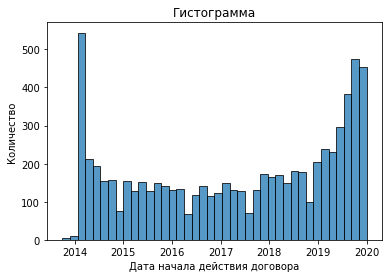

/tmp/ipykernel_70/694311451.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['begin_date'].describe()


count                    7032
unique                     76
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-01-01 00:00:00
Name: begin_date, dtype: object

In [45]:
sns.histplot(data = data,x = 'begin_date', bins = 40)
plt.xlabel('Дата начала действия договора')
plt.ylabel('Количество')
plt.title('Гистограмма')
plt.show()

data['begin_date'].describe()

Даты начала договора находятся в диапазоне от 1 февраля 2014 до 1 января 2020, большое количество дат приходится на начало 2014 года и конец 2020. 

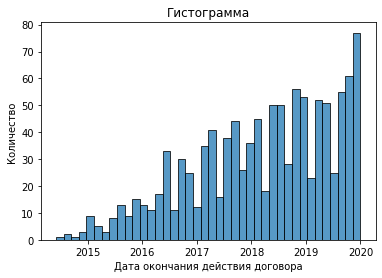

/tmp/ipykernel_70/4013897319.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['end_date'].describe()


count                    1101
unique                     66
top       2020-01-01 00:00:00
freq                       39
first     2014-06-01 00:00:00
last      2020-01-01 00:00:00
Name: end_date, dtype: object

In [46]:
sns.histplot(data = data,x = 'end_date', bins = 40)
plt.xlabel('Дата окончания действия договора')
plt.ylabel('Количество')
plt.title('Гистограмма')
plt.show()

data['end_date'].describe()

Даты окончания договора находятся в диапазоне от 1 июня 2014 до 1 января 2020, большое количество дат приходится на конец 2020.

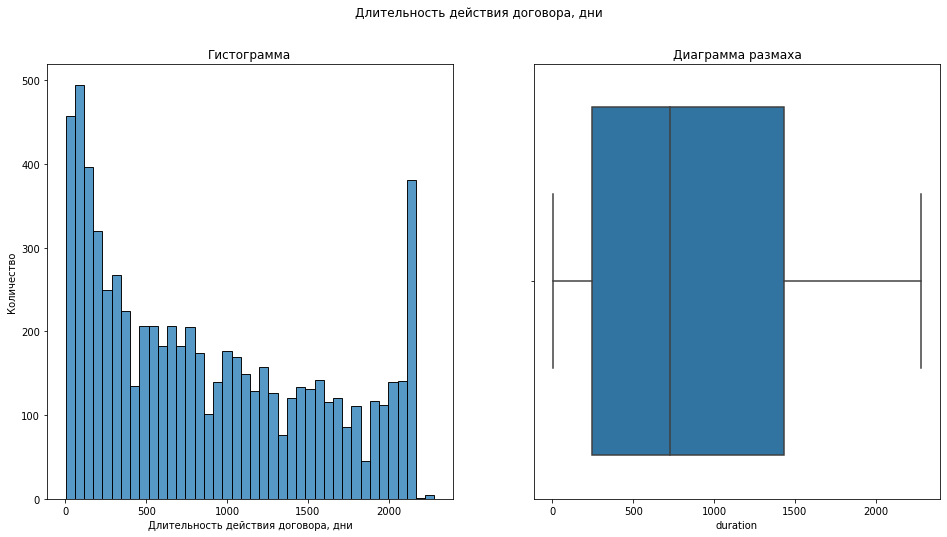

count    7032.000000
mean      874.658419
std       682.997127
min         1.000000
25%       246.000000
50%       731.000000
75%      1431.000000
max      2284.000000
Name: duration, dtype: float64

In [47]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'duration', ax=axs[0], bins = 40)
axs[0].set_xlabel('Длительность действия договора, дни')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'duration', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Длительность действия договора, дни')
plt.show()

data['duration'].describe()

Длительность договора находится в диапазоне от 28 до 2314, медиана - 761.

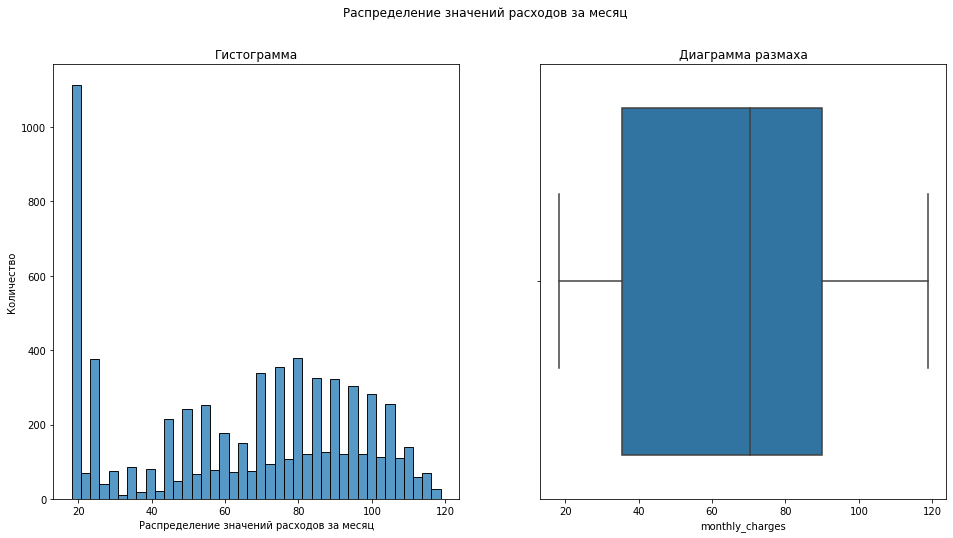

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64

In [48]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'monthly_charges', ax=axs[0], bins = 40)
axs[0].set_xlabel('Распределение значений расходов за месяц')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'monthly_charges', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Распределение значений расходов за месяц')
plt.show()

data['monthly_charges'].describe()

Показатели расходов пользователей за месяц находятся в диапазоне от 18.25 до 118.75, медиана - 70.35. Судя по гистограмме, больше всего значений около 20.

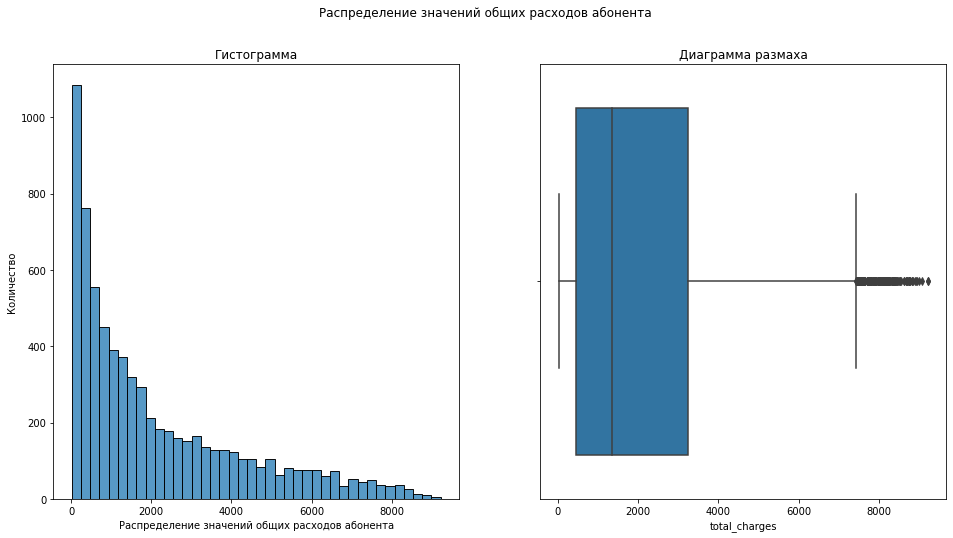

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

In [49]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'total_charges', ax=axs[0], bins = 40)
axs[0].set_xlabel('Распределение значений общих расходов абонента')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'total_charges', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Распределение значений общих расходов абонента')
plt.show()

data['total_charges'].describe()

Показатели общих расходов пользователей находятся в диапазоне от 19.05 до 9221.38, медиана - 1345.27. Данный признак обладает большим количеством выбросов.

In [50]:
boxplot = plt.boxplot(data['total_charges'].values);
outliers = boxplot['fliers'][0].get_data()[1]
df_outliers = data[data["total_charges"].isin(outliers)]
print("Количество аномалий: ", len(df_outliers))

plt.close()

Количество аномалий:  195


Аномалий достаточно много и теоретически пользователи могли потратить такую сумму денег на услуги. Не будем удалять выбросы.

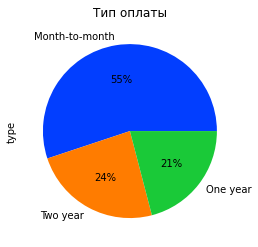

In [51]:
palette_color = sns.color_palette('bright') 
data['type'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тип оплаты', colors = palette_color)
plt.show()

Большая часть пользователей (55%) предпочитает ежемесячный тип оплаты (month-to-month), оплату за два года предпочитает 24% пользователей, за 1 год - 21%. 

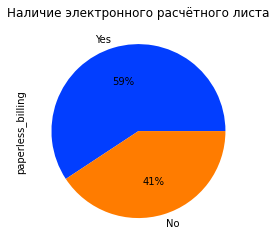

In [52]:
palette_color = sns.color_palette('bright') 
data['paperless_billing'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Наличие электронного расчётного листа', colors = palette_color)
plt.show()

У большей части пользователей (59%) есть электронный расчетный лист.

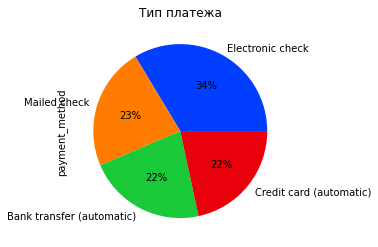

In [53]:
palette_color = sns.color_palette('bright') 
data['payment_method'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тип платежа', colors = palette_color)
plt.show()

Разные типы платежей пользуются популярностью среди пользователей: 34% предпочитает электронный чек (electronic check), 23% отправление чека по почте (mailed check), 22% автоматический банковский перевод (bank transfer), 22% автоматический платеж по кредитной карте (credit card).

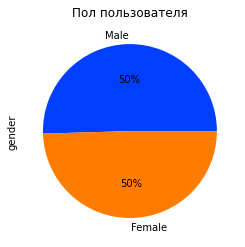

In [54]:
palette_color = sns.color_palette('bright') 
data['gender'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Пол пользователя', colors = palette_color)
plt.show()

У компании равное количество пользователей мужчин и женщин.

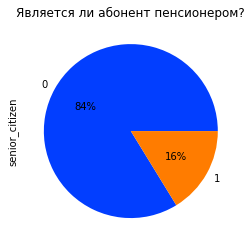

In [55]:
palette_color = sns.color_palette('bright') 
data['senior_citizen'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Является ли абонент пенсионером?', colors = palette_color)
plt.show()

16% пользователей - пенсионеры.

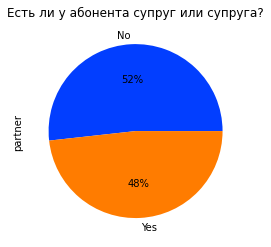

In [56]:
palette_color = sns.color_palette('bright') 
data['partner'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Есть ли у абонента супруг или супруга?', colors = palette_color)
plt.show()

Только у 48% пользователей есть супруг или супруга.

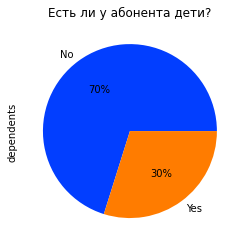

In [57]:
palette_color = sns.color_palette('bright') 
data['dependents'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Есть ли у абонента дети?', colors = palette_color)
plt.show()

Только у 30% пользователей есть дети.

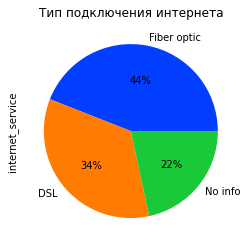

In [58]:
palette_color = sns.color_palette('bright') 
data['internet_service'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тип подключения интернета', colors = palette_color)
plt.show()

У 22% пользоваетелей интернет подключен через DSL, а у 44% через оптическое волокно.

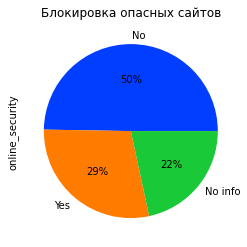

In [59]:
palette_color = sns.color_palette('bright') 
data['online_security'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Блокировка опасных сайтов', colors = palette_color)
plt.show()

У 71% пользователей не подключена блокировка опасных сайтов.

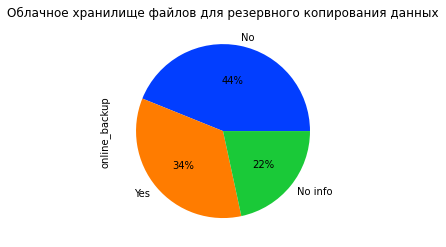

In [60]:
palette_color = sns.color_palette('bright') 
data['online_backup'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Облачное хранилище файлов для резервного копирования данных', colors = palette_color)
plt.show()

У 66% пользователей не подключено облачное хранилище файлов для резервного копирования данных.

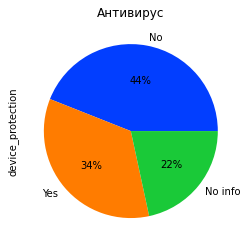

In [61]:
palette_color = sns.color_palette('bright') 
data['device_protection'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Антивирус', colors = palette_color)
plt.show()

У 66% пользователей не подключена услуга "Антивирус".

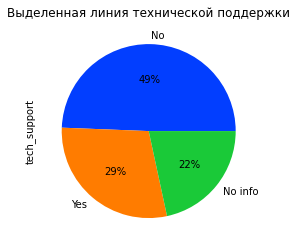

In [62]:
palette_color = sns.color_palette('bright') 
data['tech_support'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Выделенная линия технической поддержки', colors = palette_color)
plt.show()

У 71% пользователей не подключена услуга "Выделенная линия технической поддержки".

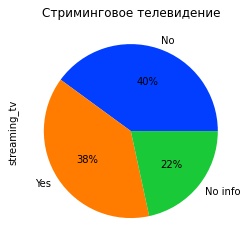

In [63]:
palette_color = sns.color_palette('bright') 
data['streaming_tv'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Cтриминговое телевидение', colors = palette_color)
plt.show()

У 62% пользователей не подключена услуга "Cтриминговое телевидение".

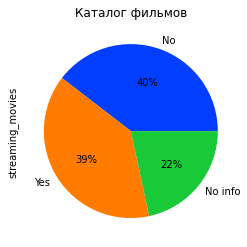

In [64]:
palette_color = sns.color_palette('bright') 
data['streaming_movies'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Каталог фильмов', colors = palette_color)
plt.show()

У 61% пользователей не подключена услуга "Каталог фильмов".

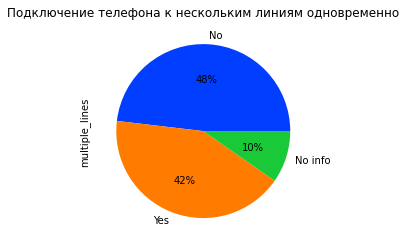

In [65]:
palette_color = sns.color_palette('bright') 
data['multiple_lines'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'Подключение телефона к нескольким линиям одновременно', colors = palette_color)
plt.show()

У 58% пользователей не подключена услуга "Подключение телефона к нескольким линиям одновременно".

Рассмотрим рапределение величин признаков относительно нашего целевого признака.

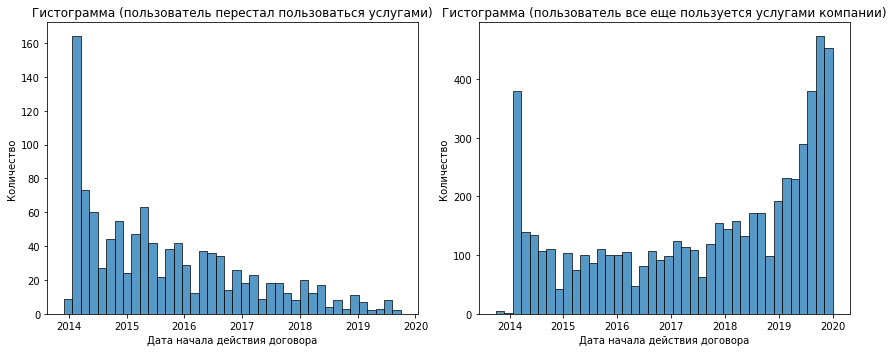

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data[data['target'] == 1], x='begin_date', bins=40, ax=axes[0])
axes[0].set_xlabel('Дата начала действия договора')
axes[0].set_ylabel('Количество')
axes[0].set_title('Гистограмма (пользователь перестал пользоваться услугами)')
sns.histplot(data=data[data['target'] == 0], x='begin_date', bins=40, ax=axes[1])
axes[1].set_xlabel('Дата начала действия договора')
axes[1].set_ylabel('Количество')
axes[1].set_title('Гистограмма (пользователь все еще пользуется услугами компании)')
plt.tight_layout()
plt.show()

Пользователи, которые все еще пользуются услугами, чаще всего заключили договор в 2019-2020 годах.

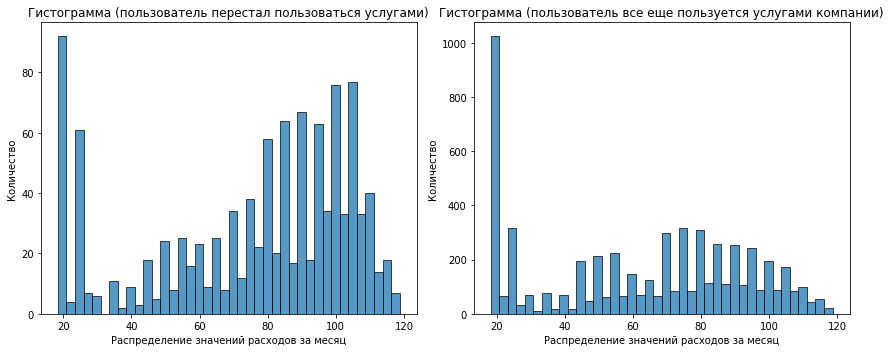

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data[data['target'] == 1], x='monthly_charges', bins=40, ax=axes[0])
axes[0].set_xlabel('Распределение значений расходов за месяц')
axes[0].set_ylabel('Количество')
axes[0].set_title('Гистограмма (пользователь перестал пользоваться услугами)')
sns.histplot(data=data[data['target'] == 0], x='monthly_charges', bins=40, ax=axes[1])
axes[1].set_xlabel('Распределение значений расходов за месяц')
axes[1].set_ylabel('Количество')
axes[1].set_title('Гистограмма (пользователь все еще пользуется услугами компании)')
plt.tight_layout()
plt.show()

Популярное значение расходов за месяц у обеих категорий - 20. У пользователей, которые перестали пользоваться услугами, расходы за месяц выше.

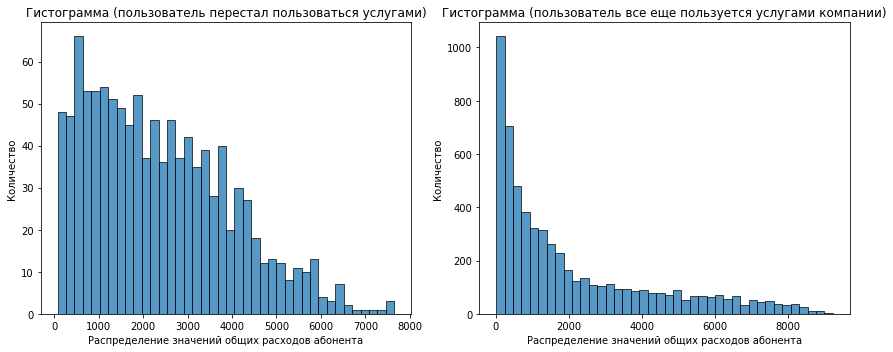

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data[data['target'] == 1], x='total_charges', bins=40, ax=axes[0])
axes[0].set_xlabel('Распределение значений общих расходов абонента')
axes[0].set_ylabel('Количество')
axes[0].set_title('Гистограмма (пользователь перестал пользоваться услугами)')
sns.histplot(data=data[data['target'] == 0], x='total_charges', bins=40, ax=axes[1])
axes[1].set_xlabel('Распределение значений общих расходов абонента')
axes[1].set_ylabel('Количество')
axes[1].set_title('Гистограмма (пользователь все еще пользуется услугами компании)')
plt.tight_layout()
plt.show()

У пользователей, которые перестали пользоваться услугами, общие расходы тоже выше.

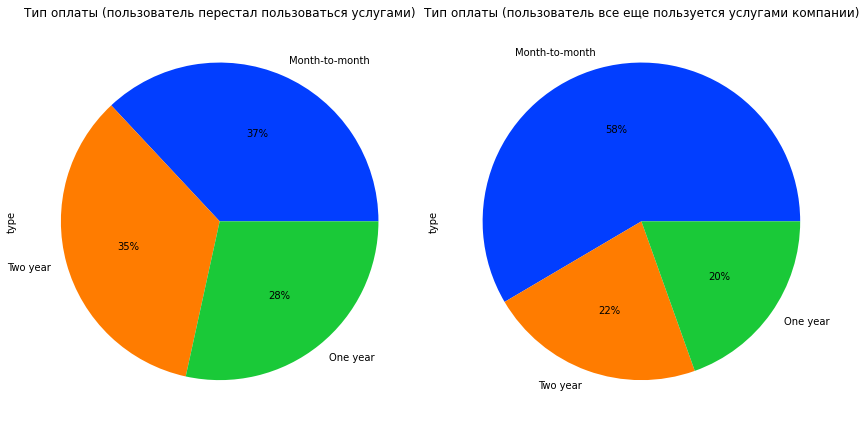

In [69]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['type'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Тип оплаты (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['type'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='Тип оплаты (пользователь все еще пользуется услугами компании)'
)
plt.tight_layout()
plt.show()

Пользователи, которые все еще пользуются услугами, наиболее популярен тип оплаты month-to-month (58%). У тех пользователей, которые не пользуются услугами, предпочтение разных способов типов оплаты распределены более равномерно. 

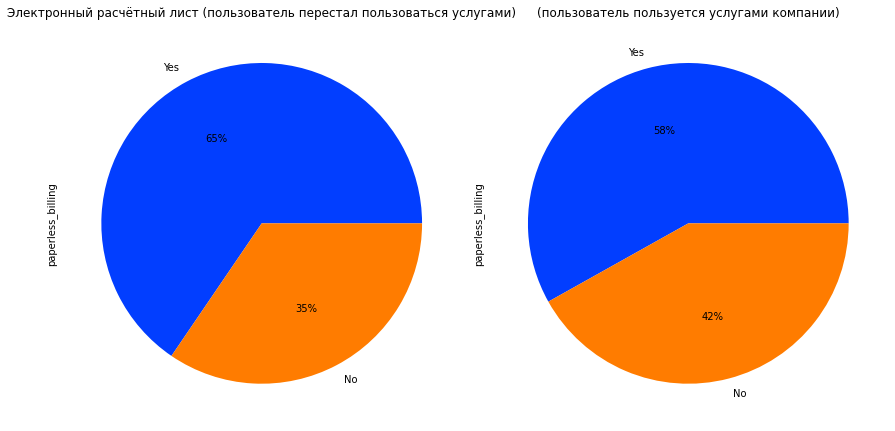

In [70]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['paperless_billing'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Электронный расчётный лист (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['paperless_billing'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами компании)'
)
plt.tight_layout()
plt.show()

65% пользователей, которые перестали пользоваться услугами компании, и 58% пользователей, которые еще пользуются услугами компании, используют электронный расчетный лист.

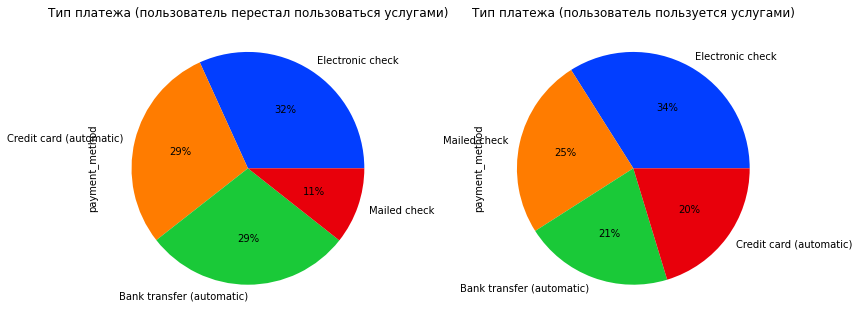

In [71]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['payment_method'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Тип платежа (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['payment_method'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='Тип платежа (пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

Процентное распределение типов платежа схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать.

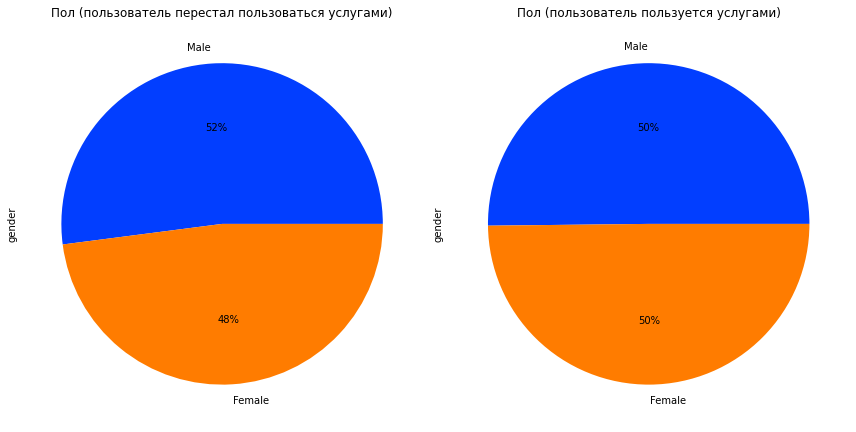

In [72]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['gender'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Пол (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['gender'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='Пол (пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

На 2% больше мужчин среди пользователей, которые перестали пользоваться услугами.

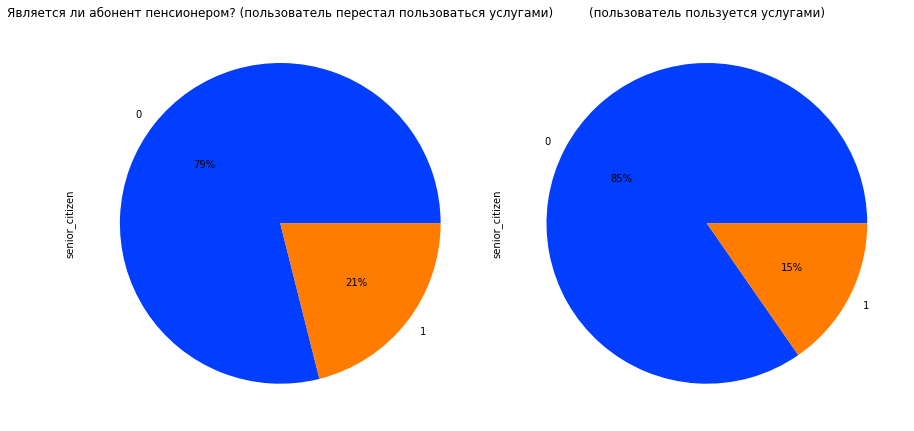

In [73]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['senior_citizen'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Является ли абонент пенсионером? (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['senior_citizen'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

85% пользователей, которые пользуются услугами, и 79% пользователей, которые перестали пользоваться, не являются пенсионерами.

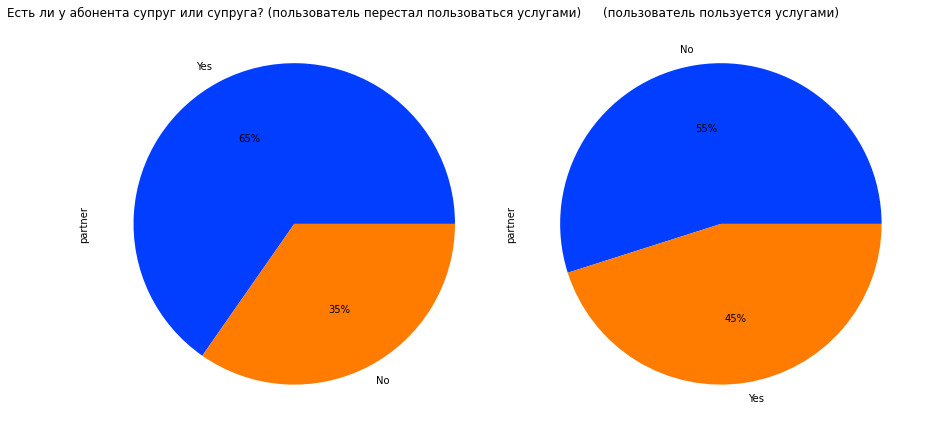

In [74]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['partner'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Есть ли у абонента супруг или супруга? (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['partner'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

Только 45% пользователей, которые пользуются услугами, и 35% пользователей, которые перестали пользоваться, имеют супруга или супругу.

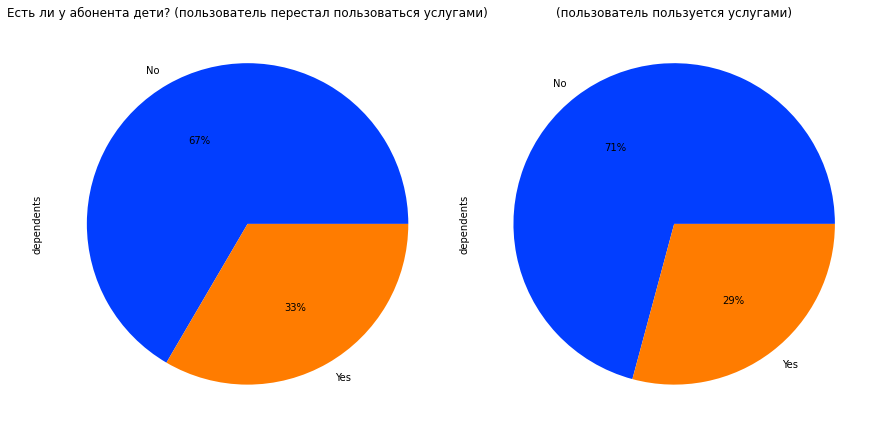

In [75]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['dependents'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Есть ли у абонента дети? (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['dependents'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

Только 29% пользователей, которые пользуются услугами, и 33% пользователей, которые перестали пользоваться, имеют детей.

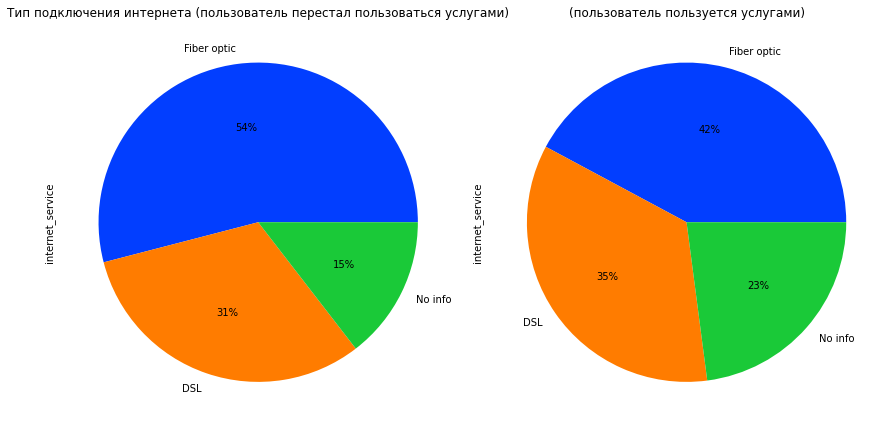

In [76]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['internet_service'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Тип подключения интернета (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['internet_service'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

Процентное распределение типов подключения интернета схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать.

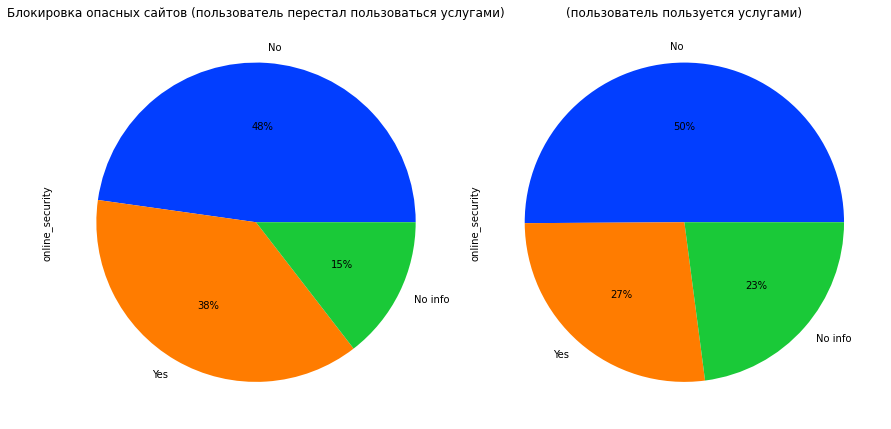

In [77]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['online_security'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Блокировка опасных сайтов (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['online_security'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

Только 27% пользователей, которые пользуются услугами, и 38% пользователей, которые перестали пользоваться, используют блокировку опасных сайтов.

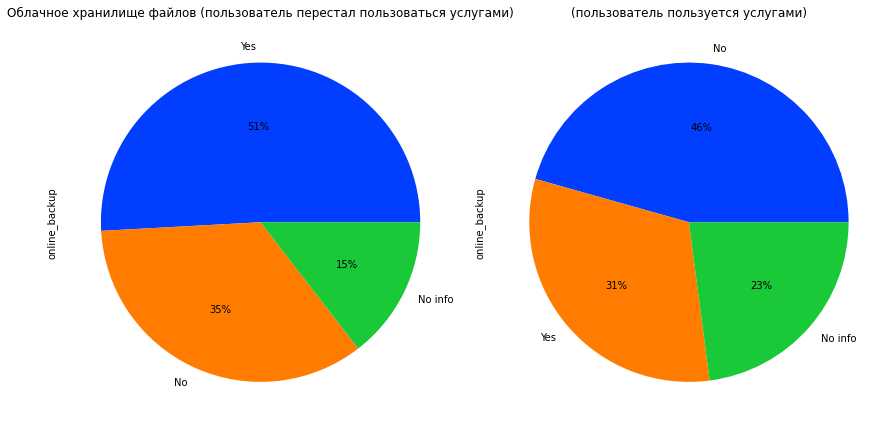

In [78]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['online_backup'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Облачное хранилище файлов (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['online_backup'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

31% пользователей используют облачное хранилище среди пользователей, которые продолжают пользоваться услугами, и 51% пользователей использовали облачное хранилище среди пользователей, которые прекратили пользоваться услугами.

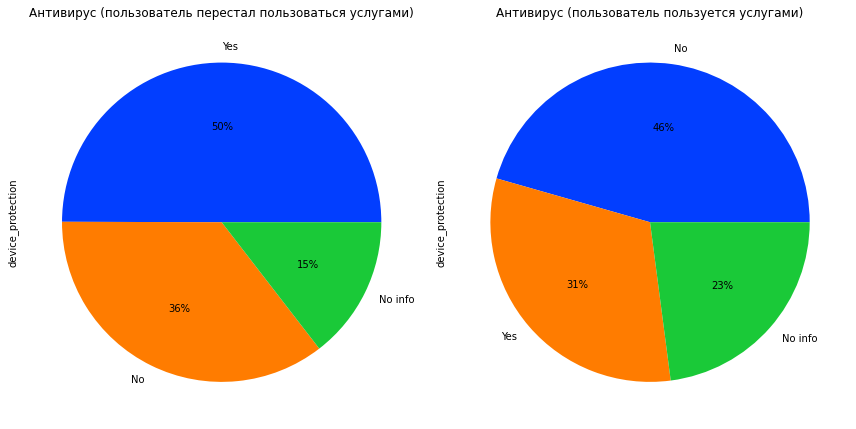

In [79]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['device_protection'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Антивирус (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['device_protection'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='Антивирус (пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

31% пользователей используют антивирус среди пользователей, которые продолжают пользоваться услугами, и 50% пользователей использовали антивирус среди пользователей, которые прекратили пользоваться услугами.

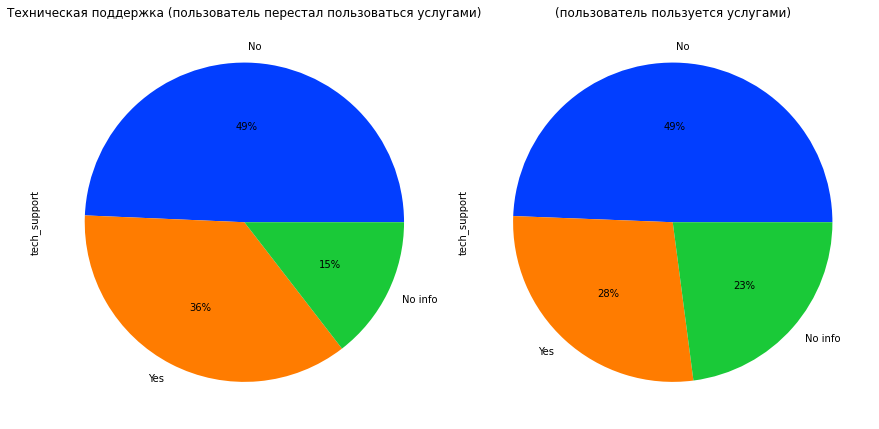

In [80]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['tech_support'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Техническая поддержка (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['tech_support'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

28% пользователей используют техническую поддержку среди пользователей, которые продолжают пользоваться услугами, и 36% пользователей использовали техническую поддержку среди пользователей, которые прекратили пользоваться услугами.

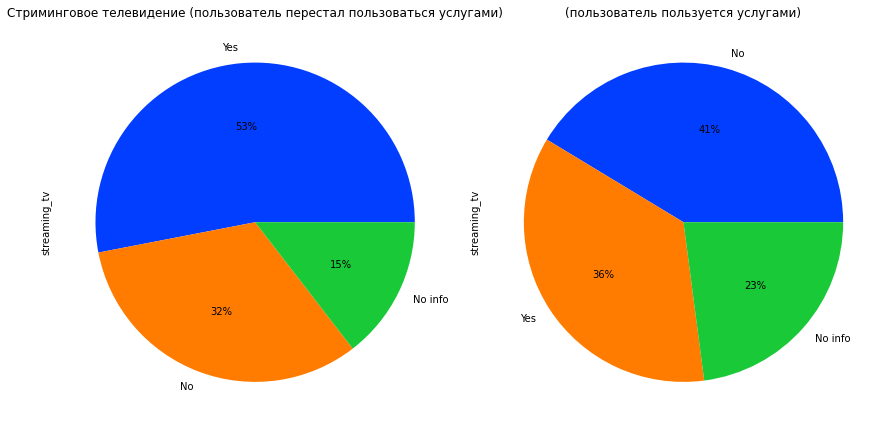

In [81]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['streaming_tv'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Cтриминговое телевидение (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['streaming_tv'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

36% пользователей используют стриминговое телевидение среди пользователей, которые продолжают пользоваться услугами, и 47% пользователей использовали стриминговое телевидение среди пользователей, которые прекратили пользоваться услугами.

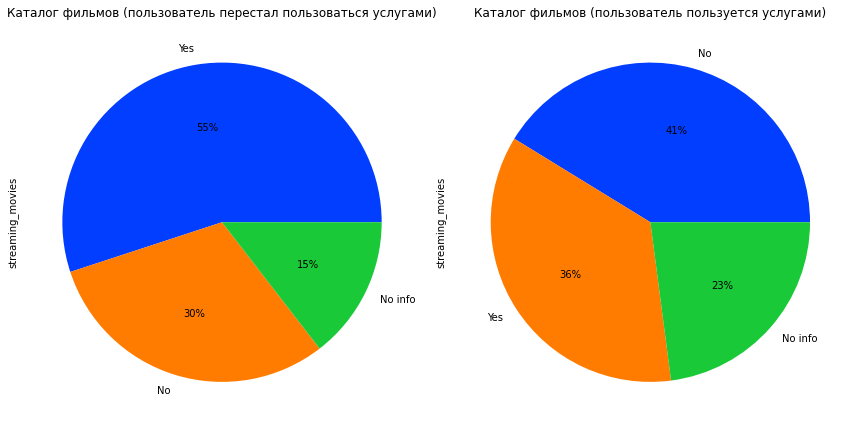

In [82]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['streaming_movies'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Каталог фильмов (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['streaming_movies'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='Каталог фильмов (пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

36% пользователей используют каталог фильмов среди пользователей, которые продолжают пользоваться услугами, и 45% пользователей использовали каталог фильмо среди пользователей, которые прекратили пользоваться услугами.

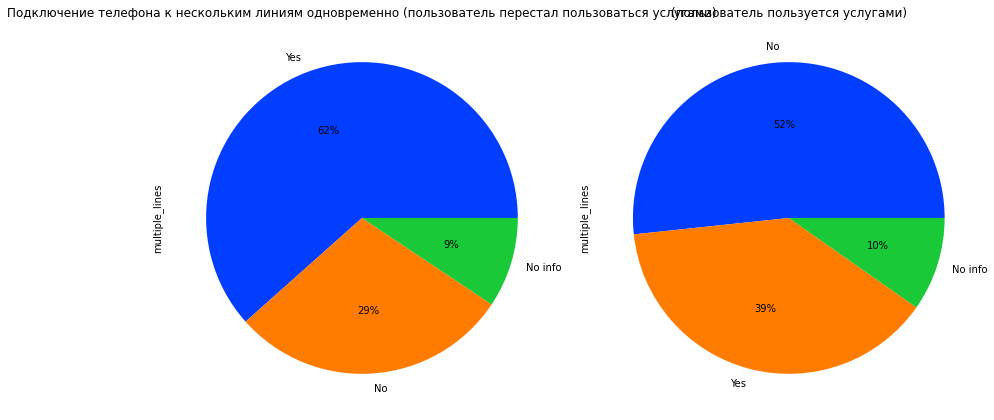

In [83]:
palette_color = sns.color_palette('bright')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
data[data['target'] == 1]['multiple_lines'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[0], 
    title='Подключение телефона к нескольким линиям одновременно (пользователь перестал пользоваться услугами)'
)
data[data['target'] == 0]['multiple_lines'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=palette_color, ax=axes[1], 
    title='(пользователь пользуется услугами)'
)
plt.tight_layout()
plt.show()

39% пользователей используют подключение телефона к нескольким линиям среди пользователей, которые продолжают пользоваться услугами, и 38% пользователей использовали подключение телефона к нескольким линиям среди пользователей, которые прекратили пользоваться услугами.

Можем удалить столбцы begin_date, end_date, end_date_filled, customer_id - они не нужны нам для построения моделей.

In [84]:
data.drop(['customer_id', 'begin_date', 'end_date', 'end_date_filled'], axis=1, inplace=True)
data.head()

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,duration
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,No info,DSL,No,Yes,No,No,No,No,0,1
1,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,No,DSL,Yes,No,Yes,No,No,No,0,1006
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,DSL,Yes,Yes,No,No,No,No,0,93
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,No info,DSL,Yes,No,Yes,Yes,No,No,0,1341
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,No,Fiber optic,No,No,No,No,No,No,0,123


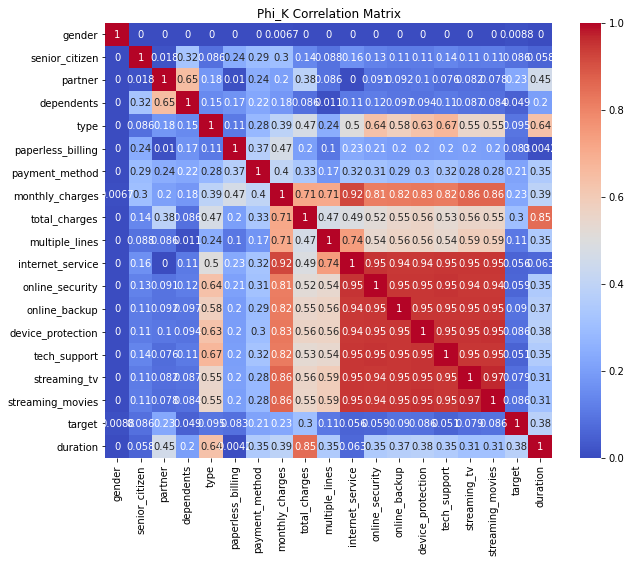

In [85]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = data.phik_matrix(
    interval_cols=['monthly_charges', 'total_charges', 'duration'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Сильная корреляция между признаками monthly_charge и streaming_movies (0.83), streaming_tv (0.84), internet_service (0.92), multiole_lines (0.68), total_charges (0.71), что логично, так как дополнительные услуги повышают расходы пользователей. Есть корреляция между наличием супруга/супруги и наличием детей (0.65).

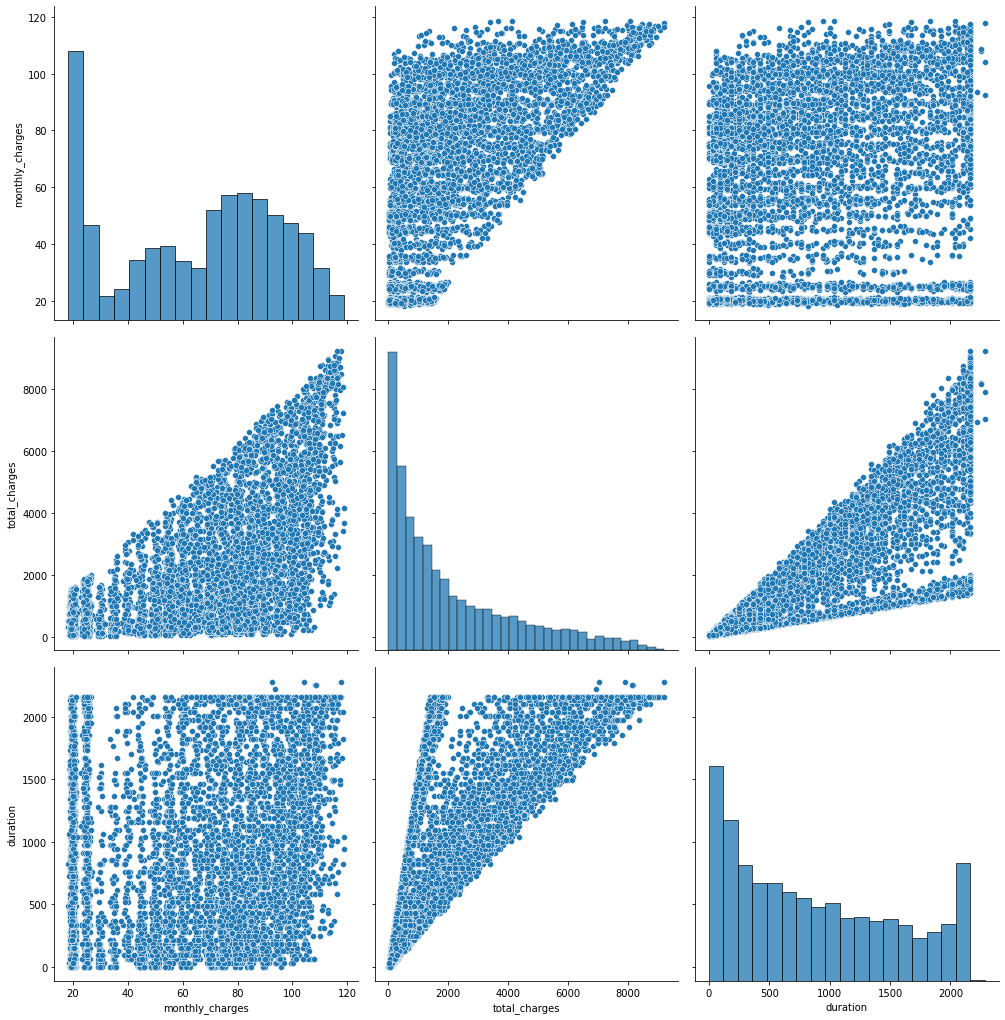

In [86]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data[['monthly_charges', 'total_charges', 'duration']])
plt.gcf().set_size_inches(15,15);

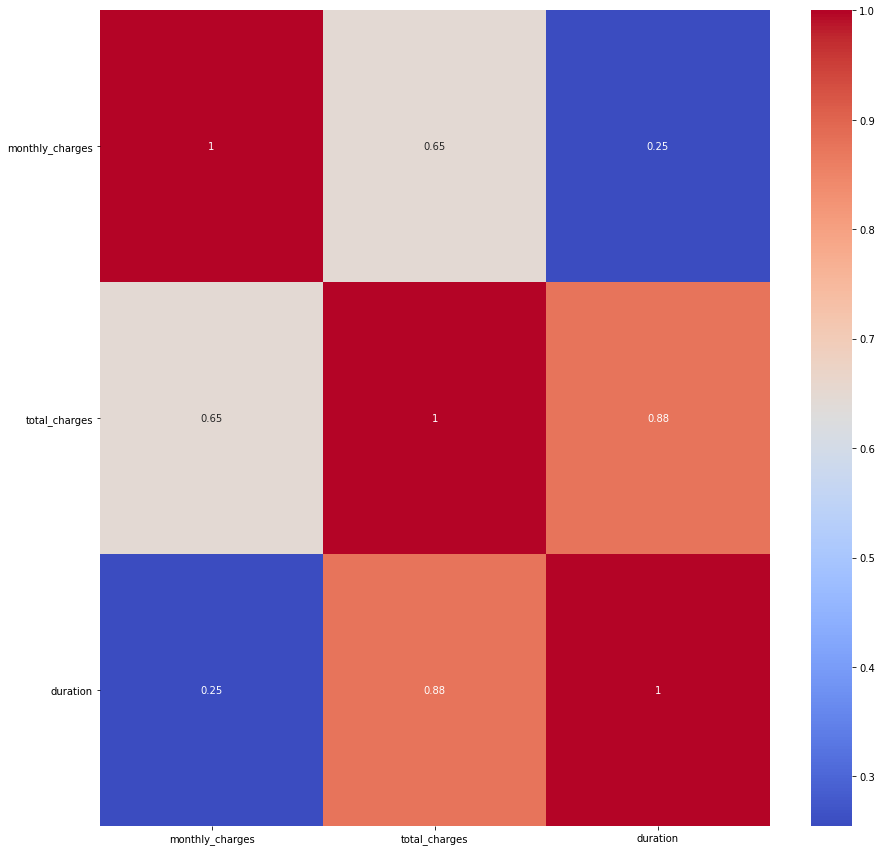

In [87]:
# рассчитаем коэффициенты корреляции между всеми признаками
analysis = data[['monthly_charges', 'total_charges', 'duration']].reset_index(
    drop=True)
sns.heatmap(analysis.corr(method= 'spearman'), cmap="coolwarm", annot=True)
plt.gcf().set_size_inches(15,15)

У total_charges есть также корреляция с duration (0.88).

Выводы:
    
Некоторые клиенты не пользовались подключением телефона к нескольким линиям одновременно и/или интернетом, в датафрейме internet и phone нет данных о них, и вследствие объединения таблиц образовались пропуски, которые нужно заполнить значением 'No'.Так же остались пропуски в end_time у тех пользователей, которые продолжают пользоваться услугами компании. Эта информация непосредственно важна нам для решения главной задачи проекта - прогнозирования оттока клиентов. Сгенерируем целевой признак и зададим следующие значения: 0 - пользователь все еще пользуется услугами компании, 1 - пользователь перестал пользоваться услугами. Добавим так же признак 'duration' для длительности подписки в днях. Найдем максимальную дату окончания подписки, но прибавим к ней один месяц для того чтобы пользователи, которые подписались в прошлом месяце, не отображались как люди с 0 дней подписки.

Даты окончания договора находятся в диапазоне от 1 июня 2014 до 1 января 2020, большое количество дат приходится на конец 2020. Длительность договора находится в диапазоне от 28 до 2314, медиана - 761. Показатели расходов пользователей за месяц находятся в диапазоне от 18.25 до 118.75, медиана - 70.35. Судя по гистограмме, больше всего значений около 20. Показатели общих расходов пользователей находятся в диапазоне от 19.05 до 9221.38, медиана - 1345.27. Данный признак обладает большим количеством выбросов. Аномалий достаточно много и теоретически пользователи могли потратить такую сумму денег на услуги. Не будем удалять выбросы. Большая часть пользователей (55%) предпочитает ежемесячный тип оплаты (month-to-month), оплату за два года предпочитает 24% пользователей, за 1 год - 21%. У большей части пользователей (59%) есть электронный расчетный лист. Разные типы платежей пользуются популярностью среди пользователей: 34% предпочитает электронный чек (electronic check), 23% отправление чека по почте (mailed check), 22% автоматический банковский перевод (bank transfer), 22% автоматический платеж по кредитной карте (credit card). У компании равное количество пользователей мужчин и женщин. 16% пользователей - пенсионеры. Только у 48% пользователей есть супруг или супруга и у 30% есть дети. У 22% пользоваетелей интернет подключен через DSL, а у 44% через оптическое волокно. У 71% пользователей не подключена блокировка опасных сайтов. У 66% пользователей не подключено облачное хранилище файлов для резервного копирования данных. У 66% пользователей не подключена услуга "Антивирус". У 71% пользователей не подключена услуга "Выделенная линия технической поддержки". У 62% пользователей не подключена услуга "Cтриминговое телевидение". У 61% пользователей не подключена услуга "Каталог фильмов".У 58% пользователей не подключена услуга "Подключение телефона к нескольким линиям одновременно".

Пользователи, которые все еще пользуются услугами, чаще всего заключили договор в 2019-2020 годах. Популярное значение расходов за месяц у обеих категорий - 20. У пользователей, которые перестали пользоваться услугами, расходы за месяц выше. У пользователей, которые перестали пользоваться услугами, общие расходы тоже выше. Пользователи, которые все еще пользуются услугами, наиболее популярен тип оплаты month-to-month (58%). У тех пользователей, которые не пользуются услугами, предпочтение разных способов типов оплаты распределены более равномерно. 65% пользователей, которые перестали пользоваться услугами компании, и 58% пользователей, которые еще пользуются услугами компании, используют электронный расчетный лист. Процентное распределение типов платежа схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать. На 2% больше мужчин среди пользователей, которые перестали пользоваться услугами. 85% пользователей, которые пользуются услугами, и 79% пользователей, которые перестали пользоваться, не являются пенсионерами. Только 45% пользователей, которые пользуются услугами, и 35% пользователей, которые перестали пользоваться, имеют супруга или супругу. Только 29% пользователей, которые пользуются услугами, и 33% пользователей, которые перестали пользоваться, имеют детей. Процентное распределение типов подключения интернета схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать. Только 27% пользователей, которые пользуются услугами, и 38% пользователей, которые перестали пользоваться, используют блокировку опасных сайтов. 31% пользователей используют облачное хранилище среди пользователей, которые продолжают пользоваться услугами, и 51% пользователей использовали облачное хранилище среди пользователей, которые прекратили пользоваться услугами. 31% пользователей используют антивирус среди пользователей, которые продолжают пользоваться услугами, и 50% пользователей использовали антивирус среди пользователей, которые прекратили пользоваться услугами. 28% пользователей используют техническую поддержку среди пользователей, которые продолжают пользоваться услугами, и 36% пользователей использовали техническую поддержку среди пользователей, которые прекратили пользоваться услугами. 36% пользователей используют стриминговое телевидение среди пользователей, которые продолжают пользоваться услугами, и 47% пользователей использовали стриминговое телевидение среди пользователей, которые прекратили пользоваться услугами. 36% пользователей используют каталог фильмов среди пользователей, которые продолжают пользоваться услугами, и 45% пользователей использовали каталог фильмов среди пользователей, которые прекратили пользоваться услугами. 39% пользователей используют подключение телефона к нескольким линиям среди пользователей, которые продолжают пользоваться услугами, и 38% пользователей использовали подключение телефона к нескольким линиям среди пользователей, которые прекратили пользоваться услугами.

Для дальнейшей работы мы можем удалить столбцы begin_date, end_date, end_date_filled, customer_id.

Сильная корреляция между признаками monthly_charge и duration (0.88), streaming_movies (0.83), streaming_tv (0.84), internet_service (0.92), multiole_lines (0.68), total_charges (0.71), что логично, так как дополнительные услуги повышают расходы пользователей. Есть корреляция между наличием супруга/супруги и наличием детей (0.65). 

##  Подготовка данных

In [88]:
# создадим списки с названиями признаков и разделим данные на обучающую и тестовую выборки
ord_columns = ['gender', 'senior_citizen', 'partner', 'dependents', 'type',	'paperless_billing', 'payment_method', 
               'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies']
num_columns = ['monthly_charges', 'total_charges', 'duration']

y = data['target']
X = data.drop(['target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
    test_size=0.25, 
    random_state=RANDOM_STATE
) 

##  Обучение моделей машинного обучения

Обучим модели KNeighborsClassifier(), DecisionTreeClassifier(), SVC() и подберем гиперпараметры.

In [89]:
# Пайплайн для кодирования порядковых признаков
ord_pipe = Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder()
        )
    ]
)

In [90]:
# объединяем все пайплайны с помощью ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [91]:
# итоговый пайплайн
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [92]:
# словари для моделей KNeighborsClassifier(), DecisionTreeClassifier(), SVC().
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
        'models__gamma': [0.01, 0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
] 

In [93]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder())]),
                                                                               ['gender',
                                                                                'senior_citizen',
                                                                                'partner',
                                                                                'dependents',
                                                                                'type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'multiple_lines',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'online_backup',
                                                                                'device_protection'...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=270125)],
                                         'models__C': range(1, 10),
                                         'models__degree': [2, 3, 4],
                                         'models__gamma': [0.01, 0.1, 1, 10],
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid', 'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=270125, scoring='roc_auc')

In [94]:
# определим наилучшую модель, найденную в процессе рандомизированного поиска
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'type', 'paperless_billing',
                                                   'payment_method',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies']),
                                                 ('num', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'duration'])])),
                ('models',
                 SVC(C=1, degree=2, gamma=0.01, kernel='poly', probability=True,
                     random_state=270125))])

In [95]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.7937837436460257


Метрика ROC-AUC лучшей модели SVC(C=1, degree=2, gamma=0.01, kernel='poly', probability=True,
    random_state=270125) на кросс-валидации равна 0.8. После просмотра записи вебинара, было решено добавить использование модели LGBMClassifier, подбор гиперпараметров проведем с помощью GridSearchCV.

In [96]:
ord_columns = ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 
               'payment_method', 'multiple_lines', 'internet_service', 'online_security', 
               'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
num_columns = ['monthly_charges', 'total_charges', 'duration']

y = data['target']
X = data.drop(['target'], axis=1)
encoder = OrdinalEncoder()
X[ord_columns] = encoder.fit_transform(X[ord_columns])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE
)

model = LGBMClassifier(random_state=RANDOM_STATE, metric='auc')
parameters = {
    'learning_rate': [0.1, 0.9],
    'n_estimators': [200, 800],
    'num_leaves': [31, 71],
    'class_weight': [None, 'balanced']
}

lgbm_grid = GridSearchCV(model, parameters, scoring='roc_auc', cv=3, n_jobs=-1)
lgbm_grid.fit(X_train, y_train)
print("Лучшие параметры:", lgbm_grid.best_params_)

Лучшие параметры: {'class_weight': 'balanced', 'learning_rate': 0.1, 'n_estimators': 800, 'num_leaves': 31}


In [97]:
lgbm_fit_score = lgbm_grid.best_score_
print('Лучшая модель и ее гиперпараметры: \n', lgbm_fit_score)

Лучшая модель и ее гиперпараметры: 
 0.8935293043939998


Таким образом, лучшая модель - LGBMClassifier с параметрами 'class_weight': 'balanced', 'learning_rate': 0.1, 'n_estimators': 800, 'num_leaves': 31. 

## Выбор лучшей модели

Проверим качество лучшей модели на тестовой выборке. 

In [98]:
model = lgbm_grid.best_estimator_
predictions = model.predict(X_test)
lin_conf_mat = confusion_matrix(y_test, predictions)

print(
    f'Количество истинно отрицательных результатов: {lin_conf_mat[0][0]}\n'
    f'Количество ложноотрицательных результатов: {lin_conf_mat[1][0]}\n'
    f'Количество истинно положительных результатов: {lin_conf_mat[1][1]}\n'
    f'Количество ложноположительных результатов: {lin_conf_mat[0][1]}\n'
)

Количество истинно отрицательных результатов: 1428
Количество ложноотрицательных результатов: 106
Количество истинно положительных результатов: 185
Количество ложноположительных результатов: 39



In [99]:
# метрика ROC-AUC
pred_proba = model.predict_proba(X_test)[:,1]
test_metric = round(roc_auc_score(y_test, pred_proba), 4)
print(f'Метрика ROC-AUC на тестовых данных - {test_metric}')

Метрика ROC-AUC на тестовых данных - 0.9361


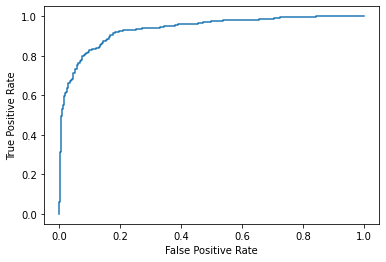

In [100]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test,  pred_proba)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [101]:
# accuracy
accuracy = round(accuracy_score(y_test, predictions), 4)
print(f'Accuracy на тестовых данных - {accuracy}')

Accuracy на тестовых данных - 0.9175


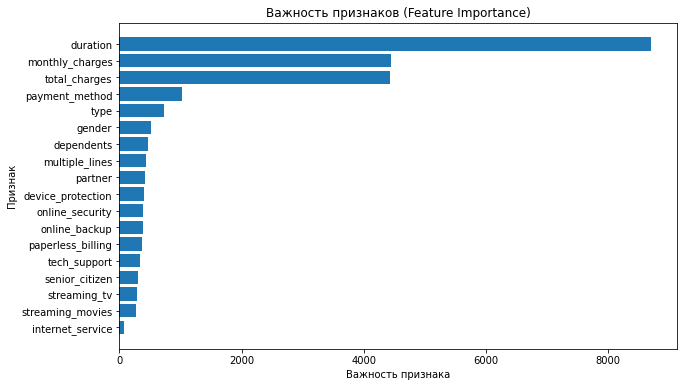

In [102]:
# получим график важности признаков
feature_importance = model.feature_importances_
feature_names = X_test.columns
sorted_idx = np.argsort(feature_importance)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков (Feature Importance)')
plt.show()

Выводы:

При проверке качества лучшей модели на тестовой выборке было выявлено, что количество истинно отрицательных результатов: 1400, количество ложноотрицательных результатов: 126, количество истинно положительных результатов: 165, количество ложноположительных результатов: 67. Метрика ROC-AUC на тестовых данных - 0.8945. Accuracy на тестовых данных - 0.8902. Важные признаки - длительность договора, платежи (за месяц и общий). Дополнительные подключенные услуги менее важны. 

## Общий вывод и рекомендации заказчику

Выводы:

При загрузке данных был проведен первичный анализ. В датафрейме data_contract 7043 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, TotalChargesm тип данных object, в столбцах MonthlyCharges тип данных float. В датафрейме data_personal 7043 записи, названия столбцов адекватны содержащимся в них данным, в столбцах SeniorCitizen тип данных int, в столбцах customerID, gender, Partner, Dependents тип данных object. В датафрейме data_internet 5517 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies тип данных object. В датафрейме data_phone 6361 записей, названия столбцов адекватны содержащимся в них данным, в столбцах customerID, MultipleLines тип данных object. Требовался исследовательский анализ и предобработка данных: изменение названий столбцов, типов столбцов, проверка наличия пропусков и дубликатов в данных.

Были проверено, нет ли пропущенных значений; наличие явных и не явных дубликатов; исправлены ошибки в написании названий столбцов; По-прежнему требовалось изменение типа данных в столбце 'total_charges' датафрейма data_contract. Для более подробного исследовательского анализа требовалось провести объединение данных. 

После объединения данных был проведен исследовательский анализ и дальнейшая подготовка данных. Некоторые клиенты не пользовались подключением телефона к нескольким линиям одновременно и/или интернетом, в датафрейме internet и phone нет данных о них, и вследствие объединения таблиц образовались пропуски, которые нужно заполнить значением 'No'.Так же остались пропуски в end_time у тех пользователей, которые продолжают пользоваться услугами компании. Эта информация непосредственно важна нам для решения главной задачи проекта - прогнозирования оттока клиентов. Был сгенерирован целевой признак со следующими значениями: 0 - пользователь все еще пользуется услугами компании, 1 - пользователь перестал пользоваться услугами. Добавим так же признак 'duration' для длительности подписки в днях. Была найдена максимальная дата окончания подписки, но прибавлен к ней один месяц для того чтобы пользователи, которые подписались в прошлом месяце, не отображались как люди с 0 дней подписки.

Даты окончания договора находятся в диапазоне от 1 июня 2014 до 1 января 2020, большое количество дат приходится на конец 2020. Длительность договора находится в диапазоне от 28 до 2314, медиана - 761. Показатели расходов пользователей за месяц находятся в диапазоне от 18.25 до 118.75, медиана - 70.35. Судя по гистограмме, больше всего значений около 20. Показатели общих расходов пользователей находятся в диапазоне от 19.05 до 9221.38, медиана - 1345.27. Данный признак обладает большим количеством выбросов. Аномалий достаточно много и теоретически пользователи могли потратить такую сумму денег на услуги. Не будем удалять выбросы. Большая часть пользователей (55%) предпочитает ежемесячный тип оплаты (month-to-month), оплату за два года предпочитает 24% пользователей, за 1 год - 21%. У большей части пользователей (59%) есть электронный расчетный лист. Разные типы платежей пользуются популярностью среди пользователей: 34% предпочитает электронный чек (electronic check), 23% отправление чека по почте (mailed check), 22% автоматический банковский перевод (bank transfer), 22% автоматический платеж по кредитной карте (credit card). У компании равное количество пользователей мужчин и женщин. 16% пользователей - пенсионеры. Только у 48% пользователей есть супруг или супруга и у 30% есть дети. У 22% пользоваетелей интернет подключен через DSL, а у 44% через оптическое волокно. У 71% пользователей не подключена блокировка опасных сайтов. У 66% пользователей не подключено облачное хранилище файлов для резервного копирования данных. У 66% пользователей не подключена услуга "Антивирус". У 71% пользователей не подключена услуга "Выделенная линия технической поддержки". У 62% пользователей не подключена услуга "Cтриминговое телевидение". У 61% пользователей не подключена услуга "Каталог фильмов".У 58% пользователей не подключена услуга "Подключение телефона к нескольким линиям одновременно".

Пользователи, которые все еще пользуются услугами, чаще всего заключили договор в 2019-2020 годах. Популярное значение расходов за месяц у обеих категорий - 20. У пользователей, которые перестали пользоваться услугами, расходы за месяц выше. У пользователей, которые перестали пользоваться услугами, общие расходы тоже выше. Пользователи, которые все еще пользуются услугами, наиболее популярен тип оплаты month-to-month (58%). У тех пользователей, которые не пользуются услугами, предпочтение разных способов типов оплаты распределены более равномерно. 65% пользователей, которые перестали пользоваться услугами компании, и 58% пользователей, которые еще пользуются услугами компании, используют электронный расчетный лист. Процентное распределение типов платежа схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать. На 2% больше мужчин среди пользователей, которые перестали пользоваться услугами. 85% пользователей, которые пользуются услугами, и 79% пользователей, которые перестали пользоваться, не являются пенсионерами. Только 45% пользователей, которые пользуются услугами, и 35% пользователей, которые перестали пользоваться, имеют супруга или супругу. Только 29% пользователей, которые пользуются услугами, и 33% пользователей, которые перестали пользоваться, имеют детей. Процентное распределение типов подключения интернета схоже для пользователей, которые перестали использовать услуги и которые продолжают их использовать. Только 27% пользователей, которые пользуются услугами, и 38% пользователей, которые перестали пользоваться, используют блокировку опасных сайтов. 31% пользователей используют облачное хранилище среди пользователей, которые продолжают пользоваться услугами, и 51% пользователей использовали облачное хранилище среди пользователей, которые прекратили пользоваться услугами. 31% пользователей используют антивирус среди пользователей, которые продолжают пользоваться услугами, и 50% пользователей использовали антивирус среди пользователей, которые прекратили пользоваться услугами. 28% пользователей используют техническую поддержку среди пользователей, которые продолжают пользоваться услугами, и 36% пользователей использовали техническую поддержку среди пользователей, которые прекратили пользоваться услугами. 36% пользователей используют стриминговое телевидение среди пользователей, которые продолжают пользоваться услугами, и 47% пользователей использовали стриминговое телевидение среди пользователей, которые прекратили пользоваться услугами. 36% пользователей используют каталог фильмов среди пользователей, которые продолжают пользоваться услугами, и 45% пользователей использовали каталог фильмов среди пользователей, которые прекратили пользоваться услугами. 39% пользователей используют подключение телефона к нескольким линиям среди пользователей, которые продолжают пользоваться услугами, и 38% пользователей использовали подключение телефона к нескольким линиям среди пользователей, которые прекратили пользоваться услугами.

Для дальнейшей работы мы можем удалить столбцы begin_date, end_date, end_date_filled, customer_id.

Выявлена сильная корреляция между признаками monthly_charge и duration (0.88), streaming_movies (0.83), streaming_tv (0.84), internet_service (0.92), multiole_lines (0.68), total_charges (0.71), что логично, так как дополнительные услуги повышают расходы пользователей. Есть корреляция между наличием супруга/супруги и наличием детей (0.65).

Были созданы списки с названиями признаков и разделены данные на обучающую и тестовую выборки. Обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), SVC(). Метрика ROC-AUC лучшей модели SVC(C=1, degree=2, gamma=0.01, kernel='poly', probability=True, random_state=270125) на кросс-валидации равна 0.79. После просмотра записи вебинара, было решено добавить использование модели LGBMClassifier, подбор гиперпараметров проведен с помощью GridSearchCV. Таким образом, лучшая модель - LGBMClassifier с параметрами 'class_weight': 'balanced', 'learning_rate': 0.1, 'n_estimators': 800, 'num_leaves': 31. 

При проверке качества лучшей модели на тестовой выборке было выявлено, что количество истинно отрицательных результатов: 1428, количество ложноотрицательных результатов: 106, количество истинно положительных результатов: 185, количество ложноположительных результатов: 39. Метрика ROC-AUC на тестовых данных - 0.8945. Accuracy на тестовых данных - 0.91. Важные признаки - длительность договора, платежи (за месяц и общий). Дополнительные подключенные услуги менее важны. 

Модель хорошо предсказывает объекты отрицательного класса (когда клиенты, фактически остающиеся в компании, предсказываются как остающиеся), но и в данных таких случаев больше. Есть небольшое количество ложных срабатываний,  модель можно еще улучшить. Но модель можно использовать для работы, поскольку она демонстрирует хорошие результаты по метрике ROC-AUC.

По результатам работы можно рекомендовать бизнесу разработать персонализированные предложения, особенно для клиентов, которые уже давно пользуются услугами компании: возможно, разработать систему скидок или специальные тарифы для поддержания лояльности, ведь именно высокие платежи в первую очередь отличают категории оставшихся клиентов и ушедших. Возможно, стоит регулярно информировать клиентов о доступных им услугах и проводить мониторинг удовлетворенности ими клиентов, чтобы повысить популярность использования дополнительных услуг. Так же стоит мониторить отток клиентов и предпринимать меры для удержания клиентов (спецпредложения/скидки).